# Data Management

In [1]:
import pandas as pd
import pandas_datareader.data as web

def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO'],data_source='quandl',\
                     begin_date='2015-01-01',end_date='2017-01-01')

In [4]:
features = pd.DataFrame(index=prices.index)
features['volume_change_ratio'] = prices.groupby(level='symbol').volume\
.diff(1) / prices.groupby(level='symbol').shift(1).volume
features['momentum_5_day'] = prices.groupby(level='symbol').close\
.pct_change(5) 

features['intraday_chg'] = (prices.groupby(level='symbol').close\
                            .shift(0) - prices.groupby(level='symbol').open\
                            .shift(0))/prices.groupby(level='symbol').open.shift(0)

features['day_of_week'] = features.index.get_level_values('date').weekday

features['day_of_month'] = features.index.get_level_values('date').day

features.dropna(inplace=True)
features.tail(10)

volume_change_ratio  momentum_5_day  intraday_chg  \
date       symbol                                                      
2016-12-23 AAPL              -0.453747        0.004743      0.008046   
           CSCO              -0.291298       -0.001961     -0.000327   
2016-12-27 AAPL               0.284036        0.005316      0.006351   
           CSCO               0.546260       -0.002276      0.001305   
2016-12-28 AAPL               0.142595       -0.001625     -0.006467   
           CSCO              -0.151900       -0.004581     -0.009121   
2016-12-29 AAPL              -0.280609       -0.002819      0.002404   
           CSCO              -0.085396        0.001315      0.002963   
2016-12-30 AAPL               1.033726       -0.004042     -0.007115   
           CSCO               0.836194       -0.007879     -0.011126   

                   day_of_week  day_of_month  
date       symbol                             
2016-12-23 AAPL              4            23  
           CSCO              4            23  
2016-12-27 AAPL              1            27  
           CSCO              1            27  
2016-12-28 AAPL              2            28  
           CSCO              2            28  
2016-12-29 AAPL              3            29  
           CSCO              3            29  
2016-12-30 AAPL              4            30  
           CSCO              4            30

In [3]:
outcomes = pd.DataFrame(index=prices.index)
# next day's opening change
outcomes['open_1'] = prices.groupby(level='symbol').open.shift(-1)\
/prices.groupby(level='symbol').close.shift(0)-1
# next day's closing change
func_one_day_ahead = lambda x: x.pct_change(-1)
outcomes['close_1'] = prices.groupby(level='symbol').close\
.apply(func_one_day_ahead)
func_five_day_ahead = lambda x: x.pct_change(-5)
outcomes['close_5'] = prices.groupby(level='symbol').close\
.apply(func_five_day_ahead)

(outcomes.tail(15))

open_1   close_1   close_5
date       symbol                              
2016-12-20 CSCO    0.004254  0.004602  0.004602
2016-12-21 AAPL   -0.006065  0.006621  0.002827
           CSCO   -0.000657 -0.001313 -0.001313
2016-12-22 AAPL   -0.006019 -0.001974  0.004058
           CSCO    0.002626 -0.002293  0.007942
2016-12-23 AAPL    0.000000 -0.006311       NaN
           CSCO    0.003603 -0.004889       NaN
2016-12-27 AAPL    0.002217  0.004282       NaN
           CSCO    0.000652  0.008547       NaN
2016-12-28 AAPL   -0.002655  0.000257       NaN
           CSCO   -0.001644 -0.001313       NaN
2016-12-29 AAPL   -0.000685  0.007857       NaN
           CSCO    0.003283  0.007942       NaN
2016-12-30 AAPL         NaN       NaN       NaN
           CSCO         NaN       NaN       NaN

In [5]:
# first, create y (a series) and X (a dataframe), with only rows where 
# a valid value exists for both y and X
y = outcomes.close_1
X = features
Xy = X.join(y).dropna()
y = Xy[y.name]
X = Xy[X.columns]
print(y.shape)
print(X.shape)

(996,)
(996, 5)


In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X,y)
print("Model RSQ: "+ str(model.score(X,y)))

print("Coefficients: ")
pd.Series(model.coef_,index=X.columns).sort_values(ascending=False)

Model RSQ: 0.015983471655375392
Coefficients: 


intraday_chg           0.150482
volume_change_ratio    0.000976
day_of_month           0.000036
day_of_week           -0.000427
momentum_5_day        -0.005543
dtype: float64

In [7]:
from sklearn.ensemble import RandomForestRegressor

y = outcomes.open_1
X = features
Xy = X.join(y).dropna()
y = Xy[y.name]
X = Xy[X.columns]
print(y.shape)
print(X.shape)

model = RandomForestRegressor(max_features=3)
model.fit(X,y)
print("Model Score: "+ str(model.score(X,y)))

print("Feature Importance: ")
pd.Series(model.feature_importances_,index=X.columns)\
.sort_values(ascending=False)

(996,)
(996, 5)
Model Score: 0.7914617831616241
Feature Importance: 


intraday_chg           0.302393
momentum_5_day         0.264553
volume_change_ratio    0.227618
day_of_month           0.136617
day_of_week            0.068819
dtype: float64

In [8]:
pd.Series(model.predict(X),index=X.index).tail(10)

date        symbol
2016-12-22  AAPL     -0.004374
            CSCO      0.002432
2016-12-23  AAPL     -0.001465
            CSCO      0.002258
2016-12-27  AAPL      0.004360
            CSCO     -0.003863
2016-12-28  AAPL     -0.001849
            CSCO     -0.000694
2016-12-29  AAPL      0.002109
            CSCO      0.000512
dtype: float64

# Feature Engineering


https://alphascientist.com/feature_engineering.html

In [9]:
import numpy as np
import pandas as pd
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO'],data_source='quandl',\
                     begin_date='2015-01-01',end_date='2017-01-01')

In [10]:
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open-1 # daily return
features['f02'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1 
features.tail()

f01       f02
date       symbol                    
2016-12-28 CSCO   -0.009121  0.000652
2016-12-29 AAPL    0.002404 -0.002655
           CSCO    0.002963 -0.001644
2016-12-30 AAPL   -0.007115 -0.000685
           CSCO   -0.011126  0.003283

### Logs

In [13]:
features['f03'] = prices.volume.apply(np.log) # log of daily volume

### Differencing

In [14]:
features['f03'] = prices.groupby(level='symbol').volume.diff() # change since prior day
features['f04'] = prices.groupby(level='symbol').volume.diff(50) # chhange since 50 days prior

### Rate of Change

In [15]:
pct_chg_fxn = lambda x: x.pct_change()
features['f05'] = prices.groupby(level='symbol').volume.apply(pct_chg_fxn) 

### Moving Averages

In [16]:
# log of 5 day moving average of volume
ma_5 = lambda x: x.rolling(5).mean()
features['f06'] = prices.volume.groupby(level='symbol').apply(ma_5)\
.apply(np.log) 

# daily volume vs. 200 day moving average
ma_200 = lambda x: x.rolling(200).mean()
features['f07'] = prices.volume/ prices.volume.groupby(level='symbol')\
.apply(ma_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50 = lambda x: x.ewm(span=50).mean()
features['f08'] = prices.close/ prices.close.groupby(level='symbol')\
.apply(ema_50)-1

### Z-Scores

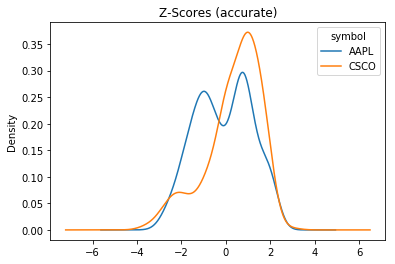

In [18]:
zscore_fun_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())\
/ x.rolling(window=200, min_periods=20).std()
features['f10'] =prices.groupby(level='symbol').close.apply(zscore_fun_improved)
features.f10.unstack().plot.kde(title='Z-Scores (accurate)')

### Percentile

In [19]:
rollrank_fxn = lambda x: x.rolling(200,min_periods=20)\
.apply(lambda x: pd.Series(x).rank(pct=True)[0])
features['f11'] = prices.groupby(level='symbol').volume.apply(rollrank_fxn)

### Cross-Sectional Rank

In [20]:
features['f12'] = features['f07'].dropna().groupby(level='date').rank(pct=True) 

### Technical Analysis

In [21]:
import ta # technical analysis library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
# money flow index (14 day)
features['f13'] = ta.momentum.money_flow_index(prices.high, 
                                               prices.low, prices.close, \
                                               prices.volume, n=14, fillna=False)
# mean-centered money flow index
features['f14'] = features['f13'] - features['f13']\
.rolling(200,min_periods=20).mean()

ModuleNotFoundError: No module named 'ta'

## Alternative Representations
### Binning

In [22]:
n_bins = 10
bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
features['f15'] = prices.volume.groupby(level='symbol').apply(bin_fxn)

### Signing

In [23]:
features['f16'] = features['f05'].apply(np.sign)

### Plus-Minus

In [24]:
plus_minus_fxn = lambda x: x.rolling(20).sum()
features['f17'] = features['f16'].groupby(level='symbol').apply(plus_minus_fxn)

### One-Hot Encoding

In [25]:
month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = prices.index # Careful!  This is forcing index values without usual pandas alignments!

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)
features.iloc[:,-12:].tail()

f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2016-12-28 CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1